In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH='/content/gdrive/MyDrive/Datasets/ptb-diagnostic-ecg-database-1.0.0'



In [ ]:
!pip install wfdb
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 15.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9632 sha256=21b245634ca78195c263d9b011d1ff9a7e2a9e3bbcfc3c842caa07f2313b9227
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


In [ ]:

import os
import random
import itertools
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
from progress.bar import Bar
import heapq
from scipy.stats.stats import pearsonr

def dataGeneration(data_path, csv_path, record_path):

    # initialize dataset
    dataset = pd.DataFrame(columns=['label', 'record'])

    if record_path == None:

        # a loop for each patient
        detail_path = data_path + '/'
        record_files = [i.split('.')[0] for i in os.listdir(detail_path) if (not i.startswith('.') and i.endswith('.hea'))]

        Bar.check_tty = False
        bar = Bar('Processing', max=len(record_files), fill='#', suffix='%(percent)d%%')

        # a loop for each record
        for record_name in record_files:

            # load record
            signal, info = wfdb.rdsamp(detail_path + record_name)

            fs = 200

            signal = processing.resample_sig(signal[:,0], info['fs'], fs)[0]

            # set some parameters
            window_size_half = int(fs * 0.125 / 2)
            max_bpm = 230

            # detect QRS peaks
            qrs_inds = processing.gqrs_detect(signal, fs=fs)
            search_radius = int(fs*60/max_bpm)
            corrected_qrs_inds = processing.correct_peaks(signal, peak_inds=qrs_inds, search_radius=search_radius, smooth_window_size=150)

            average_qrs = 0
            count = 0
            for i in range(1, len(corrected_qrs_inds)-1):
                start_ind = corrected_qrs_inds[i] - window_size_half
                end_ind = corrected_qrs_inds[i] + window_size_half + 1
                if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                    continue
                average_qrs = average_qrs + signal[start_ind: end_ind]
                count = count + 1

            # remove outliers
            if count < 8:
                print('\noutlier detected, discard ' + record_name)
                continue

            average_qrs = average_qrs / count

            corrcoefs = []
            for i in range(1, len(corrected_qrs_inds)-1):
                start_ind = corrected_qrs_inds[i] - window_size_half
                end_ind = corrected_qrs_inds[i] + window_size_half + 1
                if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                    corrcoefs.append(-100)
                    continue
                corrcoef = pearsonr(signal[start_ind: end_ind], average_qrs)[0]
                corrcoefs.append(corrcoef)

            max_corr = list(map(corrcoefs.index, heapq.nlargest(8, corrcoefs)))

            index_corr = random.sample(list(itertools.permutations(max_corr, 8)), 100)

            for index in index_corr:
                # a temp dataframe to store one record
                record_temp = pd.DataFrame()

                signal_temp = []

                for i in index:
                    start_ind = corrected_qrs_inds[i + 1] - window_size_half
                    end_ind = corrected_qrs_inds[i + 1] + window_size_half + 1
                    sig = processing.normalize_bound(signal[start_ind: end_ind], -1, 1)
                    signal_temp = np.concatenate((signal_temp, sig))

                record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
                record_temp['label'] = record_name
                record_temp['record'] = record_name

                # add it to final dataset
                dataset = dataset.append(record_temp, ignore_index=True, sort=False)
                
            bar.next()    
        bar.finish()    
    else:
        patient_folders = [i for i in os.listdir(data_path) if (not i.startswith('.') and i.startswith(record_path))]

        print(data_path, ' - ',record_path)

        Bar.check_tty = False
        bar = Bar('Processing', max=len(patient_folders), fill='#', suffix='%(percent)d%%')
        # a loop for each patient
        print(len(patient_folders))
        for patient_name in patient_folders:
            detail_path = data_path + patient_name + '/'
            record_files = [i.split('.')[0] for i in os.listdir(detail_path) if i.endswith('.hea')]

            # a loop for each record
            for record_name in record_files:

                # load record
                signal, info = wfdb.rdsamp(detail_path + record_name)

                fs = 200

                signal = processing.resample_sig(signal[:,0], info['fs'], fs)[0]

                # set some parameters
                window_size_half = int(fs * 0.125 / 2)
                max_bpm = 230

                # detect QRS peaks
                qrs_inds = processing.gqrs_detect(signal, fs=fs)
                search_radius = int(fs*60/max_bpm)
                corrected_qrs_inds = processing.correct_peaks(signal, peak_inds=qrs_inds, search_radius=search_radius, smooth_window_size=150)

                average_qrs = 0
                count = 0
                for i in range(1, len(corrected_qrs_inds)-1):
                    start_ind = corrected_qrs_inds[i] - window_size_half
                    end_ind = corrected_qrs_inds[i] + window_size_half + 1
                    if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                        continue
                    average_qrs = average_qrs + signal[start_ind: end_ind]
                    count = count + 1

                # remove outliers
                if count < 8:
                    print('\noutlier detected, discard ' + record_name + ' of ' + patient_name)
                    continue

                average_qrs = average_qrs / count

                corrcoefs = []
                for i in range(1, len(corrected_qrs_inds)-1):
                    start_ind = corrected_qrs_inds[i] - window_size_half
                    end_ind = corrected_qrs_inds[i] + window_size_half + 1
                    if start_ind<corrected_qrs_inds[i-1] or end_ind>corrected_qrs_inds[i+1]:
                        corrcoefs.append(-100)
                        continue
                    corrcoef = pearsonr(signal[start_ind: end_ind], average_qrs)[0]
                    corrcoefs.append(corrcoef)

                max_corr = list(map(corrcoefs.index, heapq.nlargest(8, corrcoefs)))

                index_corr = random.sample(list(itertools.permutations(max_corr, 8)), 100)

                for index in index_corr:
                    # a temp dataframe to store one record
                    record_temp = pd.DataFrame()

                    signal_temp = []

                    for i in index:
                        start_ind = corrected_qrs_inds[i + 1] - window_size_half
                        end_ind = corrected_qrs_inds[i + 1] + window_size_half + 1
                        sig = processing.normalize_bound(signal[start_ind: end_ind], -1, 1)
                        signal_temp = np.concatenate((signal_temp, sig))

                    record_temp = record_temp.append(pd.DataFrame(signal_temp.reshape(-1,signal_temp.shape[0])), ignore_index=True, sort=False)
                    record_temp['label'] = patient_name
                    record_temp['record'] = record_name

                    # add it to final dataset
                    dataset = dataset.append(record_temp, ignore_index=True, sort=False)
                
            bar.next()    
        bar.finish()

    # save for further use
    print(csv_path)
    dataset.to_csv(f'{PATH}/{csv_path}', index=False)

    print('processing completed')


dataset_name = PATH
record_path = 'patient'#'patient'
# root path
data_path = dataset_name + '/'

csv_path = 'ptb.csv'

dataGeneration(data_path, csv_path, record_path)

/content/gdrive/MyDrive/Datasets/ptb-diagnostic-ecg-database-1.0.0/  -  patient
290


Processing |############################### | 97%


outlier detected, discard s0544_re of patient285


Processing |################################| 100%


ptb.csv
processing completed


# CNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
import keras.backend as K
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Softmax, Conv1D, Dense, Dropout, ReLU, MaxPooling1D, Flatten
# from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import pickle



#preprocessor ptb

dataset = pd.read_csv("/content/gdrive/MyDrive/Datasets/ptb-diagnostic-ecg-database-1.0.0/ptb.csv")
x_cols = [col for col in dataset.columns if (col != 'label' and col != 'record')]
X_data = dataset[x_cols].values
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], -1))
Y_data = dataset['label'].values
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state=0, test_size = 0.3, train_size = 0.7)


num_classes = len(np.unique(Y_data))

print(num_classes,Y_train.shape,X_train.shape)
Y_train_encoder = sklearn.preprocessing.LabelEncoder()
Y_train_num = Y_train_encoder.fit_transform(Y_train)
Y_train_wide = np_utils.to_categorical(Y_train_num, num_classes)

Y_test_num = Y_train_encoder.fit_transform(Y_test)
Y_test_wide = np_utils.to_categorical(Y_test_num, num_classes)

#model cnn
input_shape = (X_train.shape[1], X_train.shape[2])
#print(input_shape)
inputs = Input(shape=input_shape)
x = Conv1D(16, 7)(inputs)
x = ReLU()(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)

x = Conv1D(32 ,5)(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)

x = Conv1D(64, 5)(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)

x = Conv1D(128, 7)(x)
x = ReLU()(x)

x = Conv1D(256, 7)(x)
x = ReLU()(x)

x = Conv1D(256, 8)(x)
x = ReLU()(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(num_classes)(x)

predictions = Softmax()(x)

cnn_model = Model(inputs=inputs, outputs=predictions)

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
cnn_model.summary()

# training
batch_size = 16
epochs = 50

# set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                    save_best_only=True, save_weights_only=False)

history = cnn_model.fit(X_train, Y_train_wide,
            batch_size=batch_size,
            epochs=epochs,
            verbose = 1,
            validation_split = 0.2,
            shuffle=True,
            callbacks=[mcp])

cnn_model.load_weights(best_weights_filepath)

    # save model
cnn_model.save('cnn_model1.h5')
cnn_model.summary()

289 (38360,) (38360, 200, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 194, 16)           128       
                                                                 
 re_lu (ReLU)                (None, 194, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            2592      
                                                                 
 re_lu_1 (ReLU)              (None, 92, 32)            0         
                                

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']

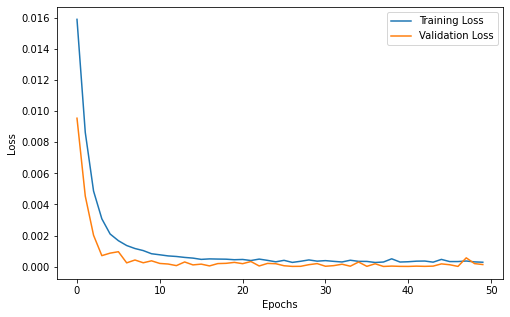

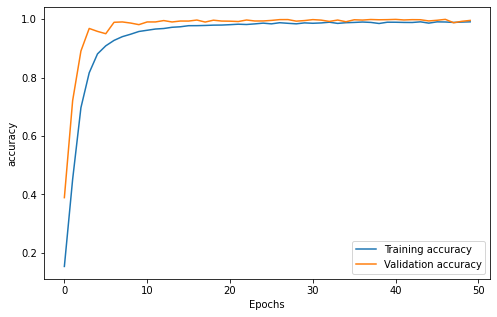

In [ ]:
plt.figure(figsize=(8, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()
plt.figure(figsize=(8, 5))
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
# plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
cnn_pred = np.argmax(cnn_model.predict(X_test), axis=-1)

# print performance details
print(metrics.classification_report(Y_test_num, cnn_pred))

514/514 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        24
           3       1.00      0.98      0.99        59
           4       1.00      1.00      1.00       146
           5       1.00      1.00      1.00        84
           6       1.00      1.00      1.00       137
           7       1.00      1.00      1.00        92
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        94
          10       1.00      1.00      1.00       116
          11       1.00      1.00      1.00        62
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        92
          14       1.00      1.00      1.00       101
          15       1.00      1.00      1.00        85
          16       1.00   

In [ ]:
THRESHOLD_CNN = 0.9
LINE_CNN = 1
# Get the index of the highest probability

cut = X_test[LINE_CNN][0:90]
prob_lstm = cut[cut>THRESHOLD_CNN]
INDEX_LSTM  =np.where(X_test[LINE_CNN][0:90]==prob_lstm[0])[0]
INDEX_LSTM



# Get the patient:

input= X_test[INDEX_LSTM[0]]
input = np.expand_dims(input, axis=0)
Y_pred = cnn_model.predict(input)
print('Patient No: ' + str(np.argmax(Y_pred,axis=1)))

1/1 [==============================] - 0s 85ms/step
Patient No: [231]


ROC AUC score: 0.9997043493880403


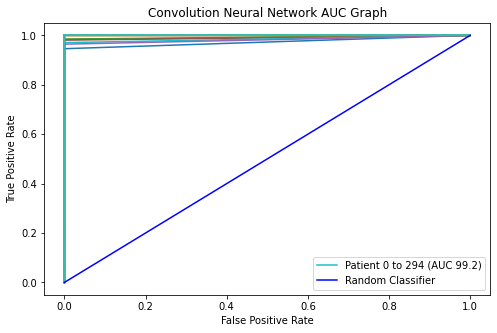

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target = np.unique(Y_data)


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize=(8, 5))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score_cnn(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    fpr, tpr=0,0
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        #c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, tpr)
    c_ax.plot(fpr, tpr, label = 'Patient 0 to 294 (AUC 99.2)')    
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Classifier')
    return roc_auc_score(y_test, y_pred, average=average)

    
print('ROC AUC score:', multiclass_roc_auc_score_cnn(Y_test_num, cnn_pred))

c_ax.legend()
c_ax.set_title('Convolution Neural Network AUC Graph')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# LSTM

In [ ]:
from keras.layers import Dense, Dropout, LSTM, Embedding,Flatten
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import tensorflow as tf
from keras.callbacks import EarlyStopping

lstm_model = Sequential()
lstm_model.add(LSTM(16, input_shape = input_shape , return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(Flatten())
lstm_model.add(Dense(num_classes, activation='Softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = lstm_model.fit(X_train, Y_train_wide, validation_split=0.1, epochs=50, shuffle=True)#, callbacks=[callback])


    # save model
lstm_model.save('lstm_model1.h5')
lstm_model.summary()

Epoch 1/50
1079/1079 [==============================] - 30s 24ms/step - loss: 2.6607 - accuracy: 0.3454 - val_loss: 1.1798 - val_accuracy: 0.6348
Epoch 2/50
1079/1079 [==============================] - 23s 21ms/step - loss: 0.7883 - accuracy: 0.7515 - val_loss: 0.5225 - val_accuracy: 0.8582
Epoch 3/50
1079/1079 [==============================] - 24s 22ms/step - loss: 0.3831 - accuracy: 0.8754 - val_loss: 0.2410 - val_accuracy: 0.9176
Epoch 4/50
1079/1079 [==============================] - 23s 22ms/step - loss: 0.2729 - accuracy: 0.9146 - val_loss: 0.1482 - val_accuracy: 0.9541
Epoch 5/50
1079/1079 [==============================] - 23s 21ms/step - loss: 0.1595 - accuracy: 0.9490 - val_loss: 0.1012 - val_accuracy: 0.9643
Epoch 6/50
1079/1079 [==============================] - 23s 21ms/step - loss: 0.1511 - accuracy: 0.9549 - val_loss: 0.0639 - val_accuracy: 0.9786
Epoch 7/50
1079/1079 [==============================] - 23s 21ms/step - loss: 0.1289 - accuracy: 0.9630 - val_loss: 0.0253 -

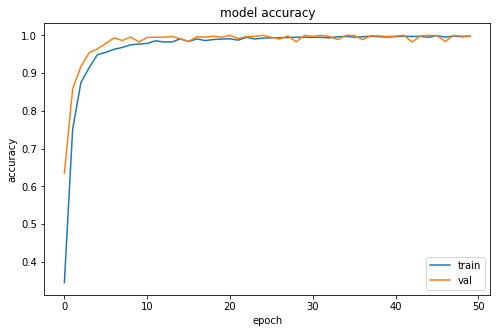

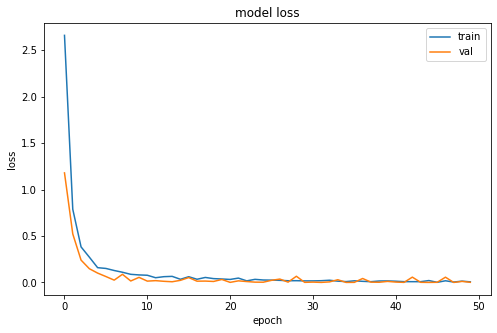

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)

# print performance details
print(metrics.classification_report(Y_test_num, lstm_pred))

514/514 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        59
           4       1.00      1.00      1.00       146
           5       1.00      1.00      1.00        84
           6       1.00      1.00      1.00       137
           7       1.00      1.00      1.00        92
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        94
          10       1.00      1.00      1.00       116
          11       1.00      1.00      1.00        62
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        92
          14       1.00      1.00      1.00       101
          15       1.00      1.00      1.00        85
          16       1.00  

In [ ]:
THRESHOLD_LSTM = 0.9
LINE_LSTM = 1

# Get the index of the highest probability

cut = X_test[LINE_LSTM][0:90]
prob_lstm = cut[cut>THRESHOLD_LSTM]
INDEX_LSTM  =np.where(X_test[LINE_LSTM][0:90]==prob_lstm[0])[0]
print(INDEX_LSTM)



# Get the patient:

input= X_test[INDEX_LSTM[0]]
input = np.expand_dims(input, axis=0)
Y_pred = lstm_model.predict(input)
print('Patient No: ' + str(np.argmax(Y_pred,axis=1)))

[12]
1/1 [==============================] - 0s 33ms/step
Patient No: [231]


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
np.unique(Y_data)

array(['patient001', 'patient002', 'patient003', 'patient004',
       'patient005', 'patient006', 'patient007', 'patient008',
       'patient009', 'patient010', 'patient011', 'patient012',
       'patient013', 'patient014', 'patient015', 'patient016',
       'patient017', 'patient018', 'patient019', 'patient020',
       'patient021', 'patient022', 'patient023', 'patient024',
       'patient025', 'patient026', 'patient027', 'patient028',
       'patient029', 'patient030', 'patient031', 'patient032',
       'patient033', 'patient034', 'patient035', 'patient036',
       'patient037', 'patient038', 'patient039', 'patient040',
       'patient041', 'patient042', 'patient043', 'patient044',
       'patient045', 'patient046', 'patient047', 'patient048',
       'patient049', 'patient050', 'patient051', 'patient052',
       'patient053', 'patient054', 'patient055', 'patient056',
       'patient057', 'patient058', 'patient059', 'patient060',
       'patient061', 'patient062', 'patient063', 'patie

ROC AUC score: 0.9983288398766003


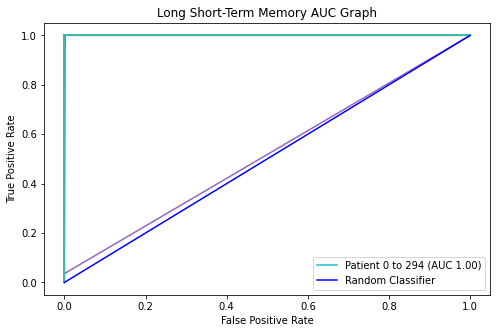

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target = np.unique(Y_data)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize=(8, 5))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    fpr, tpr=0,0
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        #c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, tpr)
    c_ax.plot(fpr, tpr, label = 'Patient 0 to 294 (AUC 1.00)')    
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Classifier')
    return roc_auc_score(y_test, y_pred, average=average)

    
print('ROC AUC score:', multiclass_roc_auc_score(Y_test_num, lstm_pred))

c_ax.legend()
c_ax.set_title('Long Short-Term Memory AUC Graph')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
Y_test_num.shape, lstm_pred.shape,Y_data.shape

((16440,), (16440,), (54800,))

In [ ]:
plt.savefig('ECG_LSTM50AUC.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>